<a href="https://colab.research.google.com/github/ThomasGoud/MasterClassSophia/blob/main/Final_AEIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto-Encoder feature extractor + Isolation Forest detector

## Data preprocessing

### Library Importation

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

### Data Downloading

In this section we download the test / train data

In [ ]:
# Definition of load_data function
def load_data(name_file):
    data = pd.read_csv(name_file)
    data['time'] = pd.to_datetime(data['time']) #converting the time column to DateTime format
    data = data.set_index(['time']) #setting the DateTime Index
    return data

# Loading training data
train_data = load_data('https://raw.githubusercontent.com/ThomasGoud/MasterClassSophia/main/train_data.csv')

# Loading test data + centering on anomaly
test_data = load_data('https://raw.githubusercontent.com/ThomasGoud/MasterClassSophia/main/test_data.csv')
test_data = test_data.iloc[5000:]

### Label Creation

We define the label, '1' when an anomaly is detected

In [ ]:
labels = pd.DataFrame(index=test_data.index.tz_localize(None),data=np.zeros(test_data.size))
labels[((labels.index>pd.Timestamp('2021-06-10 10:20:00')) & (labels.index<pd.Timestamp('2021-06-10 10:39:00')))]=1
labels[((labels.index>pd.Timestamp('2021-06-10 11:46:00')) & (labels.index<pd.Timestamp('2021-06-10 12:01:00')))]=1

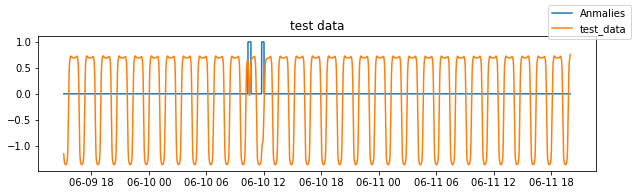

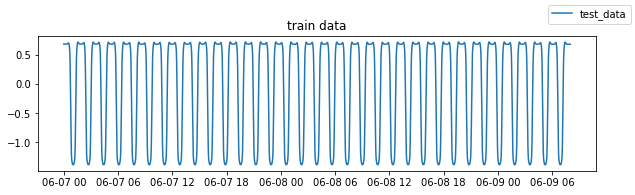

In [ ]:
# Display test data
%matplotlib inline
fig, axs = plt.subplots(figsize=(9,3))
fig.tight_layout(pad=3.0)            
axs.plot(labels, label="Anmalies")
axs.plot(test_data, label="test_data" )
axs.set_title('test data')
fig.legend()

# Display train data
fig, axs = plt.subplots(figsize=(9,3))
fig.tight_layout(pad=3.0)            
axs.plot(train_data, label="test_data" )
axs.set_title('train data')
fig.legend()

## Model Creation
Before creating the model we will define several parameters

In [ ]:
# Number of estimator for Isolation Forest
n_estimators = 400
# Auto Encoder Input/Output dimensions
window_size = 800
encoding_dim = 256

# Epoch for AE training
epochs = 12
# Number of window before weight update
batch_size = 32
# Dimension of input variable (1 value for 1 timestep )
nb_features_input = 1

### Auto-encoder

The Auto-Encoder (AE) consists in an Encoder + Decoder. 

The encoder compress the input data on Ws sample on Ls data (Ls < Ws) and the decoder is the mirror image of the encoder.

The AE is trained by giving the same output at input. The model will learn to repeat the input at output with a bottleneck at his middle.

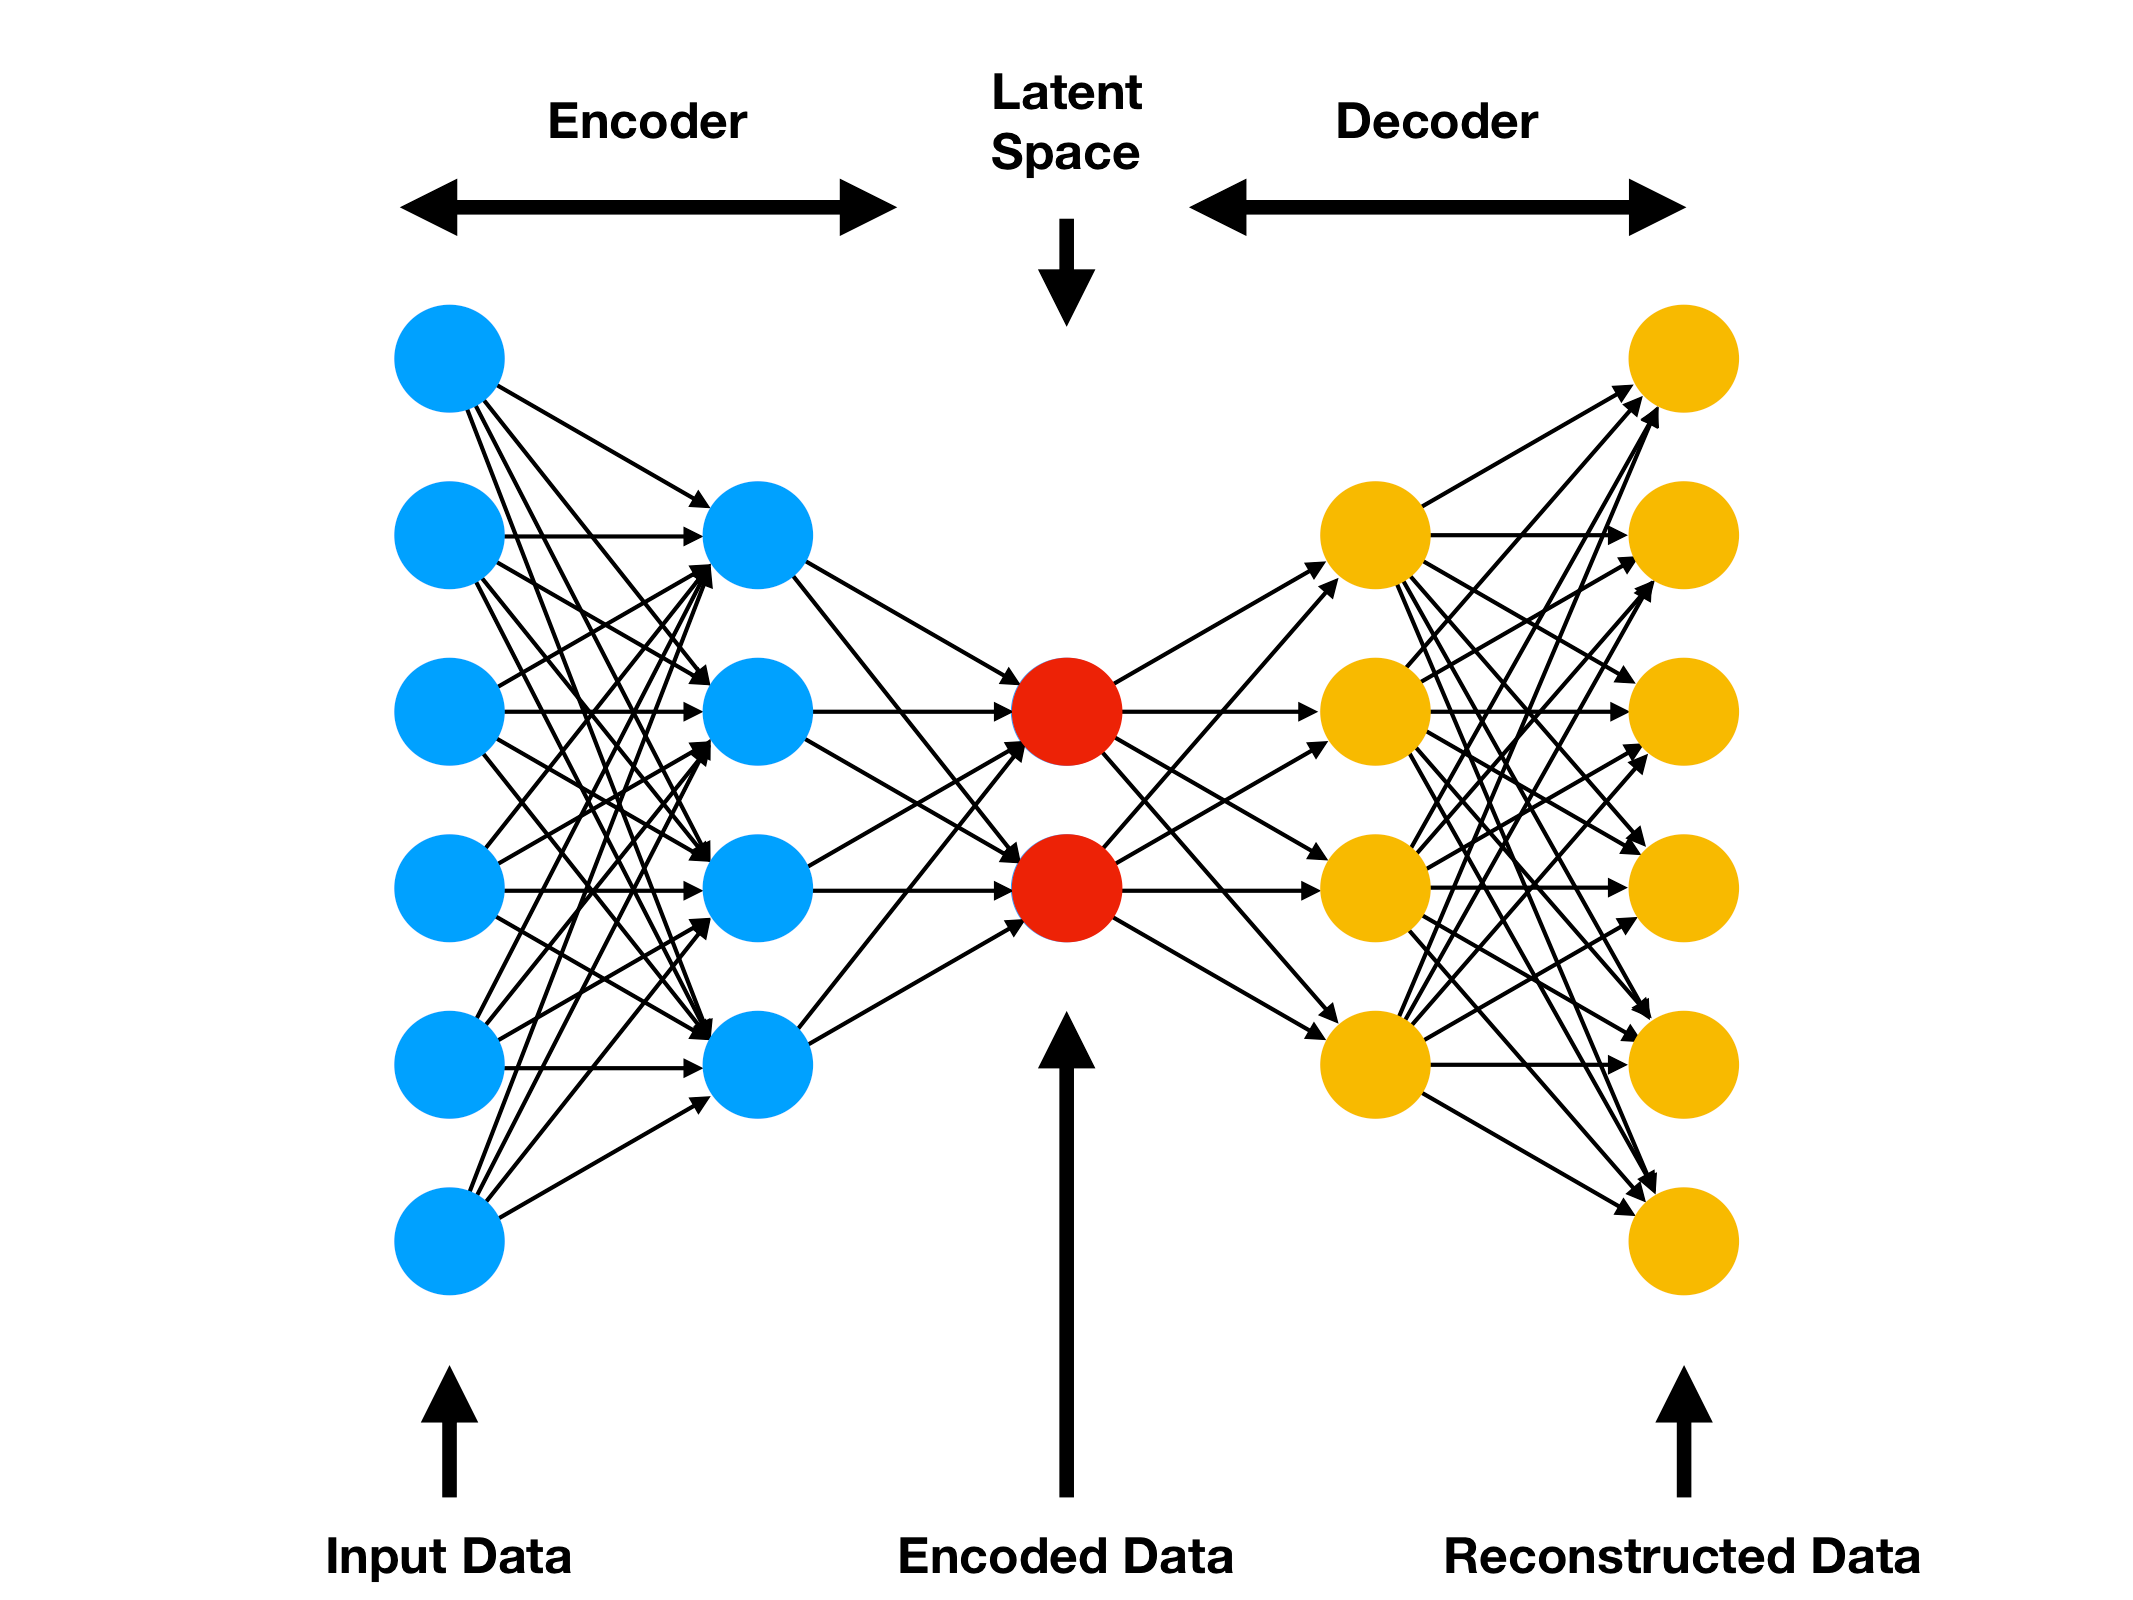

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model

Let's build an auto-encoder :

In [ ]:
input_vec = Input(shape=(window_size * nb_features_input,))
encoded = Dense(encoding_dim, name="latent_space", activation='relu')(...)
decoded = Dense(window_size * nb_features_input)(...)
autoencoder = Model(..., ...)
encoder = Model(..., ...)

autoencoder.compile(optimizer=Adam(lr=1e-3), loss='mse')
encoder.compile(optimizer='adam', loss='mse')

#### Solution

In [ ]:
input_vec = Input(shape=(window_size * nb_features_input,))
encoded = Dense(encoding_dim, name="latent_space", activation='relu')(input_vec)
decoded = Dense(window_size * nb_features_input)(encoded)
autoencoder = Model(input_vec, decoded)
encoder = Model(input_vec, encoded)

autoencoder.compile(optimizer=Adam(lr=1e-3), loss='mse')
encoder.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Isolation Forest

The isolation forest consist of a forest of regression trees.

The trees are clustering each input sample with logical conditions on its branches. 

A outlier will be easier to divide from the others points and thus, less branches will be used. 

Thus, the average depth of the input sample on the tree give a anomaly score, (less branches --> more abnormal) 

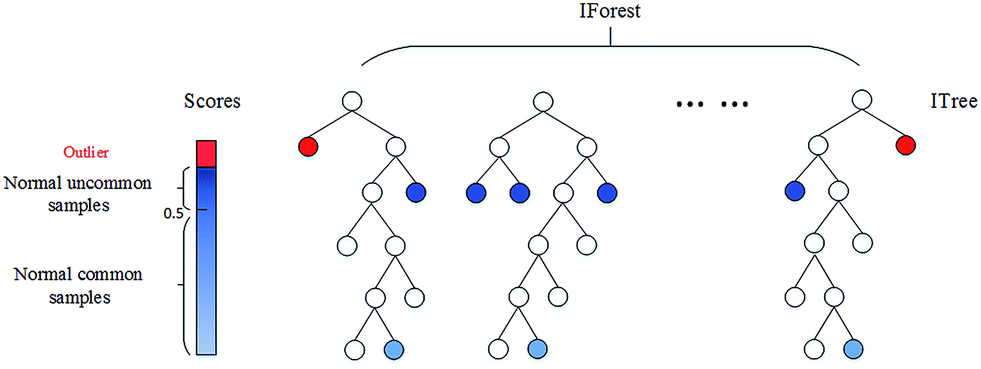

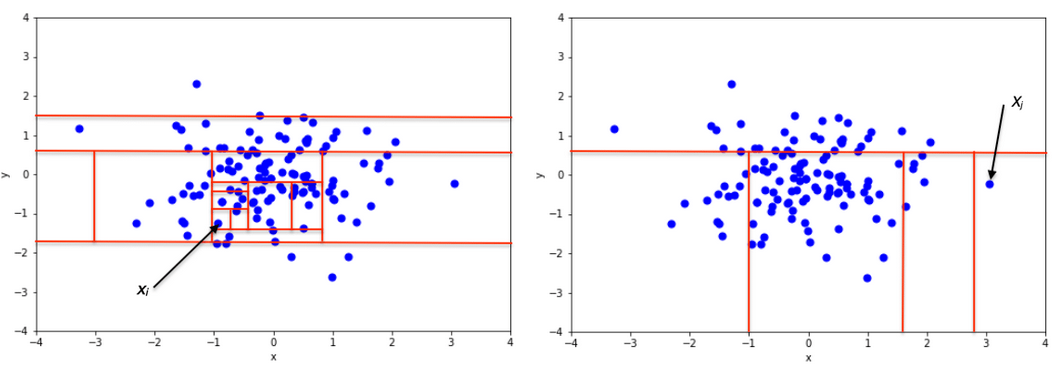

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
 # Isolation Forest Definition
detector = IsolationForest(n_estimators=...,
                       max_samples='auto', contamination=0.1, n_jobs=1,
                       verbose=0)

#### Solution

In [ ]:
 # Isolation Forest Definition
detector = IsolationForest(n_estimators=n_estimators,
                       max_samples='auto', contamination=0.1, n_jobs=1,
                       verbose=0)

## Model training 

### Data preparation

To train the model, we transform the data with a sliding window 

In [ ]:
def get_dataset_windows(df, lookback=30, lookforward=1):
    windows_dataset = []

    # iterate on the dataset to create the windows
    for i in range(0, len(df) - lookback - lookforward):
        tmp = df[i:i + lookback]
        tmp.fillna(method='pad') # remplacement des valeur vide par la valeur precedente
        windows_dataset.append(tmp)

    windows_dataset = np.stack(windows_dataset) # regroupement des fenetres
    windows_dataset -= np.expand_dims(windows_dataset.mean(axis=1), axis=1)
    return windows_dataset

In [ ]:
windows_dataset = get_dataset_windows(train_data,lookback=window_size).squeeze()

We use sklearn train_test_split function into train/validation group: 
- x_train : training data for the model
- x_val: validation data for the model 

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val = train_test_split(windows_dataset)

### Auto-Encoder model training
We train the AE by giving the same input and tell him to output the same values as input.

In [ ]:
autoencoder.fit(..., x_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(x_val, ...), verbose=1)

#### Solution

In [ ]:
autoencoder.fit(x_train, x_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(x_val, x_val), verbose=1)

Epoch 1/12
572/572 [==============================] - 4s 5ms/step - loss: 0.0156 - val_loss: 4.3179e-04
Epoch 2/12
572/572 [==============================] - 3s 5ms/step - loss: 8.6325e-04 - val_loss: 5.9598e-04
Epoch 3/12
572/572 [==============================] - 3s 5ms/step - loss: 5.9969e-04 - val_loss: 3.0848e-04
Epoch 4/12
572/572 [==============================] - 3s 5ms/step - loss: 7.2217e-04 - val_loss: 0.0011
Epoch 5/12
572/572 [==============================] - 3s 5ms/step - loss: 9.2908e-04 - val_loss: 4.8938e-04
Epoch 6/12
572/572 [==============================] - 3s 5ms/step - loss: 5.1051e-04 - val_loss: 1.2690e-04
Epoch 7/12
572/572 [==============================] - 3s 5ms/step - loss: 6.2618e-04 - val_loss: 7.0746e-05
Epoch 8/12
572/572 [==============================] - 3s 5ms/step - loss: 9.3684e-04 - val_loss: 9.5716e-04
Epoch 9/12
572/572 [==============================] - 3s 5ms/step - loss: 2.5379e-04 - val_loss: 2.8953e-04
Epoch 10/12
572/572 [===============

### Isolation Forest detector training

In [ ]:
# We use the output of the encoder to train de Isolation Forest
features = encoder.predict(windows_dataset)
detector.fit(...)

IsolationForest(contamination=0.1, n_estimators=400, n_jobs=1)

#### Solution

In [ ]:
# We use the output of the encoder to train de Isolation Forest
features = encoder.predict(windows_dataset)
detector.fit(features)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples='auto', n_estimators=400,
                n_jobs=1, random_state=None, verbose=0, warm_start=False)

## Prediction + Anomaly Score computation on test data

### Data preparation

In [ ]:
# Test data sliding window transformation
data_test = get_dataset_windows(test_data,lookback=window_size).squeeze()
data_test.shape

(22999, 800)

### Prediction
- We extract the features of data_test with the Encoder 
- We feed the IF with the features

In [ ]:
# We use the encoder to extract features
features_test = encoder.predict(...)
# Nan output transformation
features_test = np.nan_to_num(...)
# We input the features into the IF
prediction_test = detector.predict(...)

#### Solution

In [ ]:
# We use the encoder to extract features
features_test = encoder.predict(data_test)
# Nan output transformation
features_test = np.nan_to_num(features_test)
# We input the features into the IF
prediction_test = detector.predict(features_test)

### Anomaly score computation
The anomaly score is computed with decision_function which average the depth of each three

In [ ]:
# Score computation
anomaly_scores_test =  detector.decision_function(features_test) 
# Anomaly score rescaling (optional)
anomaly_scores_test = 1-((anomaly_scores_test+abs(anomaly_scores_test.min())) /
                         (anomaly_scores_test.max()- anomaly_scores_test.min()))

## Anomaly detection
We will use the anomaly score computed previously to extract 3% of data outliers

In [ ]:
# To extract the 3% of outliers, we define a threshold at 97%
th=0.98
pourcentage = th * 100
threshold = np.percentile(anomaly_scores_test, pourcentage)
binary_predict = anomaly_scores_test > threshold

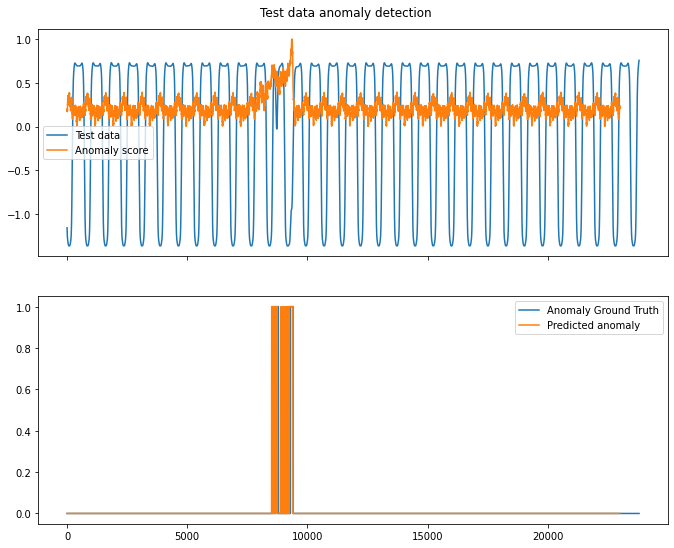

In [ ]:
# Plot
%matplotlib inline

fig, axs = plt.subplots(2,figsize=(10, 8), sharex=True)
fig.suptitle('Test data anomaly detection')
fig.tight_layout(pad=3.0)          
axs[0].plot(test_data.values,label="Test data")
axs[0].plot(anomaly_scores_test, label="Anomaly score")
axs[0].legend()
axs[1].plot(labels.values, label="Anomaly Ground Truth")
axs[1].plot(binary_predict, label="Predicted anomaly")
axs[1].legend()

## Performance of the model

### Custom Confusion Matrix definition
We use a custom function to generate the confusion matrix: we accept predicted anomalies if in the neighboorhoud of the window_size there is a labeled anomaly:

In [ ]:
def confusion_matrix_dataset( true, binary_predict):
    binary_predict = binary_predict.copy()
    tp = 0
    fn = 0
    fp = 0
    n_anomaly = 0
    # measure true positive and false negative
    # for every true anomaly : if detected add 1 true positive, if not detected add 1 false negative
    consecutive = np.split(np.where(true)[0], np.where(np.diff(np.where(true)[0]) > 1)[0] + 1)
    for anom in consecutive:
        if len(anom) < 0:
            break
        n_anomaly += 1
        detected = False
        mini = anom[0]
        maxi = anom[-1]
        for i in range(mini, maxi):
            if binary_predict[i] == 1:
                tp += 1
                detected = True
                binary_predict[mini:maxi] = 0
                break
        if not detected:
            fn += 1
    # measure false positive
    # iterate on binary predict while not all detections have been counted
    # for every false anomaly detected add 1 false positive
    for i in range(len(binary_predict)):
        if binary_predict[i] == 1:
            fp += 1
            # in order to avoid counting the same detection multiple times, we set the next windows to zero
            binary_predict[i: i + window_size] = 0

    # count number of normal windows
    n_normal = 0
    consecutive = np.split(np.where(1 - true)[0], np.where(np.diff(np.where(1 - true)[0]) > 1)[0] + 1)
    for norm in consecutive:
        n_normal += np.ceil(len(norm) / window_size)
    # true negative
    tn = n_normal - fp
    tpr = tp / n_anomaly
    fnr = fn / n_anomaly
    fpr = fp / n_normal
    tnr = tn / n_normal
    return tpr, fnr, fpr, tnr

In [ ]:
import sklearn
# roc curve and auc
tp, fn, fp, tn = confusion_matrix_dataset(labels, binary_predict)
print(pd.DataFrame([[tp*100, fn*100], [fp*100,tn*100]],columns=["Detected an anomaly (%)", "Detected normal (%)"], index=["Was an anomaly (%)","Was normal (%)"]))

                    Detected an anomaly (%)  Detected normal (%)
Was an anomaly (%)               100.000000             0.000000
Was normal (%)                     3.333333            96.666667
